### AWS SageMaker XGBoost Classification Training Model Experiment (Features and Parameters research)
Purpose: Based on the configured list of features and/or parameters train several models to compare results. CV folds are not used in the script below. See code 02 and 03 for implemeting cross-validation.

The idea is to do a **quick** comparison models with the same method (XGBoost Classification), target variable and dataset but different sets of features and/or parameters. 

The models can be trained in parallel and even with a large dataste, the result is available relatively soon comparing to sequntial run on a local server.

The output is not just a model and score (ROC-AUC) but also feature importance, test dataset evaluation score  and training/validation errors to analyze overfitting.

OpenSource XGBoost is used in the script but it can be easily replaced with SageMaker built-in XGBoost.

Main steps:

1. Experiment configuration. Instead of hardcoding datafile name, target variable, featuresets and parameters sets directly in the code I use an Excel file. Each tab with a predefined name contains featuresets for each model or parameter sets, etc. At the end, the code records the results back into the same excel file. Excel is used as an UI to easily configure experiment. 

AWS SageMaker Experiment is used also but I did not find it's very useful to track the featuresets and process and visaulaize the results (available in SageMaker notebook).

2. Preparing training and validation datasets (data preprocessing) in S3 in a format suitable for AWS Sagemaker. SKLearnProcessor and a processing job are used to create all datasets for all models in one process but the same can be done directly in the script and only the result can be moved to S3. If the datasets can be re-used from a previous experiment, only S3 location to the files can be configured instead.
Usually, testing different featuretests requires creation individual datasets per testing model and different parameters can be tested on the same dataset.

3. Training each model is done in parallel. The number of simultaneously running training jobs is contolled by a parameter (MaxNumOfRunningModels).

4. Extracting results, visualization and saving to an experiment log file.

Known issues:
1. Warnings after upgrading SageMaker to version 2:
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
Looks like warnings from XGBoost open-source estimator. No clear information about the parameters
2. All models artifacts (debugging info) are saved into output_path provided as a parameter to the estimator (expected only model.tar.gz) except source/sourcedir.tar.gz which is saved into root of a bucket from output_path. Previously everything except model.tar.gz was saved into default bucket. This is entry_point (training) script and the path is defined in SM_MODULE_DIR environment variable but there is no clue how to change it. 

In [1]:
temp_folder='/home/kate/Research/YearBuilt/Notebooks/Experiments_v2/tmp/'
Experiment_name='subsample'
#Experiments log file
Experiments_file='/home/kate/Research/YearBuilt/Experiments/DevExperiments.xlsx'
#AllExperiments_tab is a table with a list of all experiments included in the log
#Mandatory columns: Experiment (Experiment_name), Dataset(data file name), Target(target column name from Dataset)
#The rest of the columns are not use in the code below. I usually add in a free form: objective,status,result,notebook name used to conduct the experiment
AllExperiments_tab='Experiments'
#Experiment configuration:
#1.Experiment_Features_tab: differenet datasets to try
#each line in the tab contains a model name and set of features to built a dataset for SageMaker
#a feature can be an exact column name from the Dataset column in AllExperiments_tab or a calculation based on exact column names and eval pandas function
#if the experiment objective is to try different parameters sets, all models (if more then 1) can have the same feature sets.
Experiment_Features_tab='%s Features'%Experiment_name
#2. Alternatively a set of data files with preprocessed data in S3 can be provided in a form:
#Model,Training_data,Validation_data[, Testing_data, Testing_labels]
Experiment_InputData_tab='%s InputData'%Experiment_name
#3. Experiment_Params_tab: each line in the tab contains a model name and set of XGBoost parametersto apply to a model
#the set of models should be consistent in Experiment_Features_tab and Experiment_Params_tab
#parameters can be the same for all models or specific in each model
Experiment_Params_tab='%s Params'%Experiment_name

#Trial names in AWS Sage Maker experiment
Trial_name_preprocessing='%s-PreparingTrainValidData'%Experiment_name
Trial_name_training='%s-TrainingModels'%Experiment_name

#everything stored in
bucket='kdproperty'

path_to_data='Data'
path_to_training_data='Data/Experiments/%s/training'%Experiment_name
path_to_validation_data='Data/Experiments/%s/validation'%Experiment_name
path_to_testing_data='Data/Experiments/%s/testing'%Experiment_name
path_to_testing_labels='Data/Experiments/%s/labels'%Experiment_name
path_to_configuration='Config'
path_to_models='Models/Experiments/%s'%Experiment_name

#preprocessing parameters
split_year='2020'
val_size='0.25'

#level of details returning from model training
#any Y return models from a best iteration
#FeatureImportance Y/N
GetFIFlg='Y'
#Scores for Test data (should be provided in fit "test" input) Y/N
GetTestScoreFlg='Y'
#Prediction of Test data (should be provided in fit "test" input) Y/N
GetTestPredFlg='N' 

preprocessing_instance_type='ml.t3.large'
preprocessing_instance_count=1

#Training parameters
training_instance_type='ml.c5.xlarge'
training_instance_count=1

#How many simultaneously running training jobs we want to see in the system
MaxNumOfRunningModels = 30
#when a job is completes/failed or stopped a new one can be added Jobs status is checked periodically
check_training_job_every_sec=10

#What to do with teh experiment (rest of running jobs) if a training job failed or stopped
StopOnFailedModel = True

In [2]:
import sys
import time
import os

import re

import pandas as pd
import numpy as np

import boto3

import s3fs
import tarfile

from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

import sagemaker
from sagemaker.session import TrainingInput
from sagemaker.xgboost.estimator import XGBoost



import matplotlib.pyplot as plt


from sagemaker.analytics import ExperimentAnalytics

In [3]:
#should be run as a first step
#role arn is used when run from a local machine
sagemaker_execution_role = 'arn:aws:iam::757107622481:role/service-role/AmazonSageMaker-ExecutionRole-20200819T131882'

region = boto3.session.Session().region_name
sagemaker_session = sagemaker.session.Session()
s3 = s3fs.S3FileSystem()


## Experiment
Experiment is configured in an experiment log file (Excel file, in my case,  in different tabs)

1. Reading an experiment configuration (Experiment_name) from an experiment log file (Experiments_file). Target and Dataset columns in AllExperiments_tab contain data file name used and target column

In [4]:
experiments = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=AllExperiments_tab)

In [5]:
target=experiments[experiments['Experiment']==Experiment_name]['Target'].values[0]
print('Target of models in %s experiment is %s'%(Experiment_name,target))
data_file=experiments[experiments['Experiment']==Experiment_name]['Dataset'].values[0]
print('Datafile used in %s experiment is %s'%(Experiment_name,data_file))

Target of models in subsample experiment is hasclaim_water
Datafile used in subsample experiment is dwelling_basedata_v4.csv


2. Models based on individual datasets to be created, trained and compared in the experiment (Experiment_Features_tab) is a table with first column Model name (should be unique) and next columns [1:51] features to train the model. Feature is the exact column name from the dataset or a calculation based on exact column names and eval pandas function

This configuration will be used to preprocess data and also need to be moved to S3 in csv format for easy reading in a preprocessing script if we use AWS SKLearnProcessor/job/instances

In [6]:
model_features = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_Features_tab)
model_features  

,Model,F1,F2,F3,F4,F5,F6
0,BaseModel,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind


In [7]:
#we may need to get mapping between f0 - fN features in the dataset and feature importance output based on Modelname
def GetMap(model):
    feature_map={}
    df=model_features[model_features['Model']==model].loc[:, model_features.columns != 'Model']
    for i,c in enumerate(df.columns):
        feature_map['f%s'%i]=df[c].values[0]
    return feature_map

In [8]:
try:
    preprocessed_data = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_InputData_tab)
except:
    preprocessed_data = pd.DataFrame()

2b.Saving into S3 models configurations (sets of features) to be used in data preprocessing

In [9]:
if len(preprocessed_data)==0:
    Model_Config_file='%s.csv'%Experiment_name
    Models_Config_path = os.path.join(temp_folder, Model_Config_file) 

    model_features.to_csv(Models_Config_path, header=True, index=False)


    input_code = sagemaker_session.upload_data(
        Models_Config_path,
        bucket=bucket,
        key_prefix=path_to_configuration
    )

3. Model params to be used in training is a table with first column Model name (should be unique and corresponds to models in Experiment_Features_tab) and next columns are XGBoost parameters
In a general case, all models can have the same parameters

In [10]:
model_params = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_Params_tab)
model_params

,Model,objective,eval_metric,booster,scale_pos_weight,colsample_bylevel,colsample_bytree,eta,max_depth,num_round,subsample
0,BaseModel,binary:logistic,auc,gbtree,0.3,0.2,0.8,0.02,3,5000,0.2
1,BaseModel,binary:logistic,auc,gbtree,0.3,0.3,0.8,0.02,3,5000,0.3
2,BaseModel,binary:logistic,auc,gbtree,0.3,0.4,0.8,0.02,3,5000,0.4
3,BaseModel,binary:logistic,auc,gbtree,0.3,0.5,0.8,0.02,3,5000,0.5
4,BaseModel,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,3,5000,0.6
5,BaseModel,binary:logistic,auc,gbtree,0.3,0.7,0.8,0.02,3,5000,0.7
6,BaseModel,binary:logistic,auc,gbtree,0.3,0.8,0.8,0.02,3,5000,0.8
7,BaseModel,binary:logistic,auc,gbtree,0.3,0.9,0.8,0.02,3,5000,1.0


4.Verification if we have the same set of models in both configurations

In [11]:
models_from_model_features=model_features['Model'].tolist()
models_from_model_params=model_params['Model'].tolist()
if len([x for x in models_from_model_features if x not in models_from_model_params])!=0:
    raise Exception('Different set of models in featuresets and parametersets!')
if len(preprocessed_data)>0:
    models_from_preprocessed_data=preprocessed_data['Model'].tolist()
    if len([x for x in models_from_preprocessed_data if x not in models_from_model_params])!=0:
        raise Exception('Different set of models in input data and parametersets!')

5.Creating experiments and trials in SageMaker

In [12]:
#sys.path.append('/home/kate/Research/YearBuilt/Notebooks/Experiments')
import ExperimentsUtils as eu

In [13]:
eu.cleanup_experiment(Experiment_name)
eu.create_experiment(Experiment_name)
eu.create_trial(Experiment_name,Trial_name_preprocessing)
eu.create_trial(Experiment_name,Trial_name_training)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials

## Data preprocessing

1. We may not need an AWS SKLearnProcessor/job/instances for relatively small and medium datasets (unless our data are already in S3 and it takes time and money to download)
What's important is to save the prepared datasets in a predefined S3 location to be used in training.
In a case of really huge datasets and instensive, time consuming preprocessing, a separate SKLearnProcessor/job for each model can be created with more then 1 powerful instance.

Preprocessing script below reads the data from the input dataset, model configurations (desired featuresets), seprate 2020 (split_year) as a test dataset (not used in the experiment, because the data may be not complete developed in the year) and split the rest of the data to training and validation datasets. 

Training and validation datasets are saved in AWS SageMaker form (first column is a target, no header) in csv format. The location and filenames are based on model names: folder name is a model name and file names also contain a model name.

In [14]:
%%writefile preprocessing_for_all_models.py

#Training and Validation dataset for SageMaker are the same structure: no headers, the first column is a target and the rest are features


import argparse
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

if __name__=='__main__':
    
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_file', type=str)
    parser.add_argument('--split_year', type=int)     
    parser.add_argument('--val_size', type=float)     
    parser.add_argument('--target', type=str)      
    parser.add_argument('--config_file', type=str)     
    args, _ = parser.parse_known_args()    
    print('Received arguments {}'.format(args))
    
   
    target_column=args.target
    input_data_path = os.path.join('/opt/ml/processing/input', args.data_file)
    config_data_path = os.path.join('/opt/ml/processing/config', args.config_file)
    
    print('Reading input data from {}'.format(input_data_path))
    dataset = pd.read_csv(input_data_path, error_bad_lines=False, index_col=False)
    dataset_test=dataset[(dataset.cal_year == args.split_year)]
    dataset=dataset[(dataset.cal_year < args.split_year)]    
    

    print('Reading config data from {}'.format(config_data_path))
    models = pd.read_csv(config_data_path, error_bad_lines=False, index_col=False)    
    

    #iterating thru config file with models and featureset
    for index, row in models.iterrows():
        model=row['Model']
        print (index, ': Creating datasets for model %s'%model)
        featureset=row[1:51].tolist()
        featureset=[x for x in featureset if str(x) != 'nan']
        print(','.join(featureset))
        
        #creating dataset for a model according to configured dataset
        X = pd.DataFrame()
        X_test = pd.DataFrame()        
        for f in featureset:
            X[f]=dataset.eval(f)
            X_test[f]=dataset_test.eval(f)            
        y=dataset.eval(target_column)
        y_test=dataset_test.eval(target_column) 
        
        print('Testing data...')
        test_data_output_path = '/opt/ml/processing/output/testing_data/%s/'%model              
        if not os.path.exists(test_data_output_path):
            os.makedirs(test_data_output_path)       
        test_data_output_path = os.path.join(test_data_output_path,  'testing_%s.csv'%(model))     
        test_dataset=pd.DataFrame({target_column:y_test}).join(X_test)
        test_dataset.to_csv(test_data_output_path, header=False, index=False)

        
        
        #separating training and validation 
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=args.val_size, random_state=42)
        
        print('Train data...')        
        if not os.path.exists('/opt/ml/processing/output/training_data/%s'%model):
            os.makedirs('/opt/ml/processing/output/training_data/%s'%model)
        train_data_output_path = os.path.join('/opt/ml/processing/output/training_data/%s'%model, 'training_%s.csv'%model) 
        
        training_dataset=pd.DataFrame({target_column:y_train}).join(X_train)
        training_dataset.to_csv(train_data_output_path, header=False, index=False)

        print('Validation data...')                
        if not os.path.exists('/opt/ml/processing/output/validation_data/%s'%model):
            os.makedirs('/opt/ml/processing/output/validation_data/%s'%model)
        validation_data_output_path = os.path.join('/opt/ml/processing/output/validation_data/%s'%model, 'validation_%s.csv'%model)        
        
        validation_dataset=pd.DataFrame({target_column:y_val}).join(X_val)   
        validation_dataset.to_csv(validation_data_output_path, header=False, index=False)

Overwriting preprocessing_for_all_models.py


2. Preprocessing output (training and validation datasets) are saved separately for each model in a folder with the same name as a models name configured in the experiment

In [15]:
if len(preprocessed_data)==0:
    data_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=sagemaker_execution_role,
                                     instance_type=preprocessing_instance_type,
                                     instance_count=preprocessing_instance_count)    
    data_processor.run(code='preprocessing_for_all_models.py',
                            inputs=[ProcessingInput(input_name='data',source='s3://%s/%s/%s'%(bucket,path_to_data,data_file),destination='/opt/ml/processing/input'),
            ProcessingInput(input_name='config',source='s3://%s/%s/%s'%(bucket,path_to_configuration,Model_Config_file),destination='/opt/ml/processing/config'),
                                   ],
                        outputs=[ProcessingOutput(output_name='training_data', source='/opt/ml/processing/output/training_data',destination='s3://%s/%s/'%(bucket,path_to_training_data)),                                 
                                 ProcessingOutput(output_name='validation_data', source='/opt/ml/processing/output/validation_data',destination='s3://%s/%s/'%(bucket,path_to_validation_data)),                                      
                                 ProcessingOutput(output_name='testing_data', source='/opt/ml/processing/output/testing_data',destination='s3://%s/%s/'%(bucket,path_to_testing_data))
                                ],
                        arguments=['--data_file',data_file,
                                 '--split_year',split_year,
                                 '--target',target,                                    
                                 '--config_file',Model_Config_file],
                        experiment_config = {
        'ExperimentName': Experiment_name ,
        'TrialName' : Trial_name_preprocessing,
        'TrialComponentDisplayName' : '%s-%s'%(Trial_name_preprocessing,'-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())),},
                    wait=True
                     )
else:
    print('Data already preprocessed in S3')

Data already preprocessed in S3


In [16]:
#in a case a previous step started preprocesing (nothing provided in InputData) Stop the execution if there is an issue with creating input data for the models
if len(preprocessed_data)==0:
    job_name=data_processor.jobs[-1].describe()['ProcessingJobName']
    if not(sagemaker_session.was_processing_job_successful(job_name)):
        raise Exception('Preprocessing job Failed!')    

3. The created output is saved in the experiment log. The log will be used to create training jobs. It's also possible to re-use already created training and validation files in other experiments. In this case, instead of feature sets per model just provide the table in a form:Model, Training_data, Validation_data for further processing

In [17]:
#was not tested on more then 1 row in model_feature
if len(preprocessed_data)==0:
    preprocessed_data = pd.DataFrame(columns=['Model', 'Training_data', 'Validation_data', 'Testing_data'])
    for index, row in model_features.iterrows():
        model=row['Model']
        train_input = 's3://%s/%s/%s/'%(bucket,path_to_training_data,model)
        validation_input = 's3://%s/%s/%s/'%(bucket,path_to_validation_data,model)
        test_data = 's3://%s/%s/%s/testing_%s.csv'%(bucket,path_to_testing_data,model,model) 
        preprocessed_data.loc[index]=[model, train_input,validation_input,test_data]
    #preprocessed_data = pd.concat([preprocessed_data,model_features.drop('Model',axis=1)], axis=1)
    #Saving into the Experiment log file names of created training and validation datasets in S3
    eu.SaveToExperimentLog(Experiments_file, '%s InputData'%Experiment_name, preprocessed_data)

In [18]:
preprocessed_data

,Model,Training_data,Validation_data,Testing_data,F1,F2,F3,F4,F5,F6
0,BaseModel,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind


## Model training

1. Custom script to train a model. It's requred for open-source SageMaker XGBoost container used further in the notebook. The script returns some additional information (feature importance, test dataset scores and train/validation errors) from training for custom processing. The custom output is saved in output.tar.gz.

In [19]:
%%writefile ModelTraining.py

#  Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License").
#  You may not use this file except in compliance with the License.
#  A copy of the License is located at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  or in the "license" file accompanying this file. This file is distributed
#  on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#  express or implied. See the License for the specific language governing
#  permissions and limitations under the License.
from __future__ import print_function

import argparse
import json
import logging
import os
import pandas as pd
import pickle as pkl

from sagemaker_containers import entry_point
from sagemaker_xgboost_container.data_utils import get_dmatrix
from sagemaker_xgboost_container import distributed

import xgboost as xgb

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score

def _xgb_train(params, dtrain, evals, num_boost_round, early_stopping_rounds, model_dir, output_data_dir, GetFIFlg,GetTestScoreFlg,GetTestPredFlg, is_master):
    """Run xgb train on arguments given with rabit initialized.

    This is our rabit execution function.

    :param args_dict: Argument dictionary used to run xgb.train().
    :param is_master: True if current node is master host in distributed training,
                        or is running single node training job.
                        Note that rabit_run will include this argument.
    """
    progress = dict()
    booster = xgb.train(params=params,
                        dtrain=dtrain,
                        evals=evals,
                        maximize=True,
                        num_boost_round=num_boost_round,
                        early_stopping_rounds=early_stopping_rounds,
                        evals_result=progress,
                        verbose_eval=100)
    
    print('Eval results')    
    train_error=progress['train']['auc']
    eval_error=progress['validation']['auc']
    results_pd=pd.DataFrame({'train':train_error,'valid':eval_error},columns=['train','valid'])
    
    
    #feature importance
    if GetFIFlg=='Y':
        fi_weight =booster.get_score(importance_type='weight')
        fi_gain = booster.get_score(importance_type='gain')
        fi_cover= booster.get_score(importance_type='cover')
        fi_weight_pd = pd.DataFrame(fi_weight.items(),columns=['feature','weight'])
        fi_gain_pd = pd.DataFrame(fi_gain.items(),columns=['feature','gain'])
        fi_cover_pd = pd.DataFrame(fi_cover.items(),columns=['feature','cover'])
        fi_pd=pd.merge(fi_gain_pd, fi_weight_pd, on='feature', how='inner')
        fi_pd=pd.merge(fi_pd, fi_cover_pd, on='feature', how='inner')

    #Prediction on test data ...
    if 'Y' in (GetTestScoreFlg,GetTestPredFlg):
        df_prediction=pd.DataFrame()
        df_prediction['actual']=dtest.get_label()
        df_prediction['pred']=booster.predict(dtest)
   
        #Test scores from test prediction   
        df_score = pd.DataFrame()
        df_score['roc-auc-test']=[roc_auc_score(df_prediction['actual'], df_prediction['pred'])]
    
    if is_master:
        model_location = model_dir + '/xgboost-model'
        pkl.dump(booster, open(model_location, 'wb'))
        logging.info("Stored trained model at {}".format(model_location))
        
        if not os.path.exists(output_data_dir):
            os.makedirs(output_data_dir)

        result_location = os.path.join(output_data_dir, 'eval_results.csv')
        print('Saving eval results at {}'.format(result_location))
        logging.info('Saving eval results at {}'.format(result_location))
        results_pd.to_csv(result_location, header=True, index=False)
        
        if GetFIFlg=='Y':
            fi_location = os.path.join(output_data_dir, 'fi.csv')
            print('Saving feature importance at {}'.format(fi_location))
            logging.info('Saving feature importance at {}'.format(fi_location))
            fi_pd.to_csv(fi_location, header=True, index=False)
        
        if GetTestPredFlg=='Y':
            predictions_location = os.path.join(output_data_dir, 'test_predictions.csv')
            print('Saving test predictions at {}'.format(predictions_location))
            logging.info('Saving test predictions at {}'.format(predictions_location))
            df_prediction.to_csv(predictions_location, header=True, index=False)
            
        if GetTestScoreFlg=='Y':        
            test_score_location = os.path.join(output_data_dir, 'test_score.csv')
            print('Saving test score  at {}'.format(test_score_location))
            logging.info('Saving test score  at {}'.format(test_score_location))        
            df_score.to_csv(test_score_location, header=True, index=False)

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters are described here.
    parser.add_argument('--max_depth', type=int,)
    parser.add_argument('--eta', type=float)
    parser.add_argument('--objective', type=str)
    parser.add_argument('--num_round', type=int)

    parser.add_argument('--early_stopping_rounds', type=int)
    parser.add_argument('--booster', type=str)
    parser.add_argument('--eval_metric', type=str)
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--scale_pos_weight', type=float)
    parser.add_argument('--colsample_bylevel', type=float)
    parser.add_argument('--colsample_bytree', type=float)
    parser.add_argument('--subsample', type=float)
    parser.add_argument('--max_delta_step', type=int)
    
    
    parser.add_argument('--GetFIFlg', type=str, default='N')
    parser.add_argument('--GetTestScoreFlg', type=str, default='N')
    parser.add_argument('--GetTestPredFlg', type=str, default='N')            
            

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    
    parser.add_argument('--output_data_dir', type=str, default=os.environ.get('SM_OUTPUT_DATA_DIR'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    parser.add_argument('--sm_hosts', type=str, default=os.environ.get('SM_HOSTS'))
    parser.add_argument('--sm_current_host', type=str, default=os.environ.get('SM_CURRENT_HOST'))

    args, _ = parser.parse_known_args()

    # Get SageMaker host information from runtime environment variables
    sm_hosts = json.loads(args.sm_hosts)
    sm_current_host = args.sm_current_host

    dtrain = get_dmatrix(args.train, 'csv')
    dval = get_dmatrix(args.validation, 'csv')
    watchlist = [(dtrain, 'train'), (dval, 'validation')] if dval is not None else [(dtrain, 'train')]

      
    dtest = get_dmatrix(args.test, 'csv')
    if not(dtest):
        if ((args.GetTestScoreFlg=='Y') | (args.GetTestPredFlg=='Y')):
            raise Exception('Please provide test data in a test channel for prediction and scores or set GetTestScoreFlg and GetTestPredFlg to N')
            
    train_hp = {
        'max_depth': args.max_depth,
        'eta': args.eta,
        'objective': args.objective,
        'booster': args.booster,
        'seed': args.seed,
        'eval_metric':args.eval_metric,
        'scale_pos_weight':args.scale_pos_weight,
        'colsample_bylevel': args.colsample_bylevel,
        'colsample_bytree': args.colsample_bytree,
        'subsample': args.subsample,
        'max_delta_step':args.max_delta_step
        }

    xgb_train_args = dict(
        params=train_hp,
        dtrain=dtrain,
        evals=watchlist,
        num_boost_round=args.num_round,
        early_stopping_rounds=args.early_stopping_rounds,
        model_dir=args.model_dir,
        output_data_dir=args.output_data_dir,
        GetFIFlg=args.GetFIFlg,
        GetTestScoreFlg=args.GetTestScoreFlg,
        GetTestPredFlg=args.GetTestPredFlg)

    if len(sm_hosts) > 1:
        # Wait until all hosts are able to find each other
        entry_point._wait_hostname_resolution()

        # Execute training function after initializing rabit.
        distributed.rabit_run(
            exec_fun=_xgb_train,
            args=xgb_train_args,
            include_in_training=(dtrain is not None),
            hosts=sm_hosts,
            current_host=sm_current_host,
            update_rabit_args=True
        )
    else:
        # If single node training, call training method directly.
        if dtrain:
            xgb_train_args['is_master'] = True
            _xgb_train(**xgb_train_args)
        else:
            raise ValueError("Training channel must have data to train model.")

#not clear what's this for multi-node training?
def model_fn(model_dir):
    """Deserialize and return fitted model.

    Note that this should have the same name as the serialized model in the _xgb_train method
    """
    model_file = 'xgboost-model'
    booster = pkl.load(open(os.path.join(model_dir, model_file), 'rb'))
    return booster

Writing ModelTraining1.py


2. For each parameter set we create an estimator and train it using training and validation datasets created in previous step and saved in a predefined location 
based on Model name. 

The train and valid files locations are saved in preprocessed_data dataframe. 

Since we built our training jobs based on preconfigured parameters and train/valid locations the data in 2 configuration must be consistent (the same model names).

Only configured number (MaxNumOfRunningModels) of models is running at the same time. The process starts initial MaxNumOfRunningModels models and waits till 
one of them Complete, Failed or Stopped (StopOnFailedModel=False only).
If a model training job Failed or Stopped and StopOnFailedModel is True, the whole process is broken

In [20]:
models_from_preprocessed_data=preprocessed_data['Model'].tolist()
models_from_model_params=model_params['Model'].tolist()
if len([x for x in models_from_preprocessed_data if x not in models_from_model_params])!=0:
    raise Exception('Different set of models in preprocessed_data and parametersets!')
#using merge because, in general, we can have different number of rows in each dataframe - folds in data and different sets of params
data_for_training=pd.merge(model_params, preprocessed_data, on='Model', how='inner')

,Model,objective,eval_metric,booster,scale_pos_weight,colsample_bylevel,colsample_bytree,eta,max_depth,num_round,subsample,Training_data,Validation_data,Testing_data,F1,F2,F3,F4,F5,F6
0,BaseModel,binary:logistic,auc,gbtree,0.3,0.2,0.8,0.02,3,5000,0.2,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
1,BaseModel,binary:logistic,auc,gbtree,0.3,0.3,0.8,0.02,3,5000,0.3,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
2,BaseModel,binary:logistic,auc,gbtree,0.3,0.4,0.8,0.02,3,5000,0.4,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
3,BaseModel,binary:logistic,auc,gbtree,0.3,0.5,0.8,0.02,3,5000,0.5,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
4,BaseModel,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,3,5000,0.6,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
5,BaseModel,binary:logistic,auc,gbtree,0.3,0.7,0.8,0.02,3,5000,0.7,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
6,BaseModel,binary:logistic,auc,gbtree,0.3,0.8,0.8,0.02,3,5000,0.8,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
7,BaseModel,binary:logistic,auc,gbtree,0.3,0.9,0.8,0.02,3,5000,1.0,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind


In [21]:
CntRunningInst = 0

processors=list()

#regexpression to exclude features (F1..F25) from the list of parameters
regex = re.compile('F[ 0-9]')

for index, row in data_for_training.iterrows():
    model='%s-%s'%(row['Model'],index)
    print(model)
    #1. Verifying training and validation data exists (were created in preprocessing step or moved manually in a predefined location)

    if not(s3.exists(row['Training_data']) & s3.exists(row['Validation_data'])):           
        print('Training and Validation data do not exist. Skipping model %s'%(model))
        print('Check Training data in %s'%row['Training_data'])
        print('Check Validation data in %s'%row['Validation_data'])              
        continue
    #2. Do we have available instances slots to run the model? It depends on number of allowed in teh account simultaneously running specific instance types,
    #number of instance type configured per model and configured number of model running
    if CntRunningInst >= MaxNumOfRunningModels * training_instance_count: #not enough slots to add a model
        print('There is no slot to train  %s model. Waiting...'%model)
        #Waiting till a taining job complete
        while CntRunningInst >= MaxNumOfRunningModels * training_instance_count:
            print('.', end='')
            time.sleep(check_training_job_every_sec)            
            for p in processors:
                ModelFailed=False
                name=p.jobs[-1].describe()['TrainingJobName']
                status=p.jobs[-1].describe()['TrainingJobStatus']
                dummyFlag=not(StopOnFailedModel)
                #job completed, failed or stopped (and do not stop the process) then we a slot is free
                if (
                    (status=='Completed') | 
                    ( ((status=='Failed') | 
                       (status=='Stopped')
                      ) & 
                      dummyFlag
                    )
                   ):
                    print('')
                    print('Job %s  is %s'%(name,status))
                    print('Continue training...')
                    CntRunningInst = CntRunningInst - training_instance_count
                    processors.remove(p)
                    break
                elif ( ((status=='Failed') | (status=='Stopped')) & StopOnFailedModel) :
                    raise Exception('Model %s training failed!'%name)
    #3. there is a slot to add a model training job
    print('Creating training job for  %s model'%model)
    #parameters
    #techically early_stopping_rounds are not XGBoost parameters but it's an easy way to send them into the training/CV process
    hyperparameters = {
        'early_stopping_rounds':100,
        'seed': 42,
        'GetFIFlg':GetFIFlg,
        'GetTestScoreFlg':GetTestScoreFlg,
        'GetTestPredFlg':GetTestPredFlg 
    } 
    for i, param in enumerate(data_for_training.columns):
        #skip first column with Model name and dataset names or features
        #if do not exclude then they will be added into experiment analytics as parameters but not used in training anyway
        if ((param in ('Model','Training_data','Validation_data','Testing_data','Testing_labels')) | (bool(re.match(regex, param)))):
            continue
        hyperparameters[param] = row[param]
    print(hyperparameters)
    
    #training and validation data from preprocessing
    train_input = TrainingInput(row['Training_data'], content_type='text/csv')
    validation_input = TrainingInput(row['Validation_data'], content_type='text/csv')
    test_input = TrainingInput(row['Testing_data'], content_type='text/csv')
    #Estimator

    
    training_job_name = model+'-'+time.strftime('%Y-%m-%d-%H-%M-%S', time.gmtime())
    xgb_script_mode_estimator = XGBoost(
        entry_point='ModelTraining.py',
        hyperparameters=hyperparameters,
        role=sagemaker_execution_role, 
        instance_count=training_instance_count,
        instance_type=training_instance_type,
        framework_version='1.2-1',
        output_path='s3://%s/%s/'%(bucket,path_to_models)
        )
    
    #Training
    xgb_script_mode_estimator.fit({'train': train_input, 'validation': validation_input,'test':test_input}, job_name=training_job_name, wait=False,
    experiment_config = {
        'ExperimentName': Experiment_name ,
        'TrialName' : Trial_name_training,
        'TrialComponentDisplayName' : '%s-%s'%(Trial_name_training,model.replace('_','-')),})
              
    processors.append(xgb_script_mode_estimator)

    CntRunningInst = CntRunningInst + training_instance_count
    # to prevent throttling
    time.sleep(.5)

        
    
    

BaseModel-0


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Creating training job for  BaseModel-0 model
{'early_stopping_rounds': 100, 'seed': 42, 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.2, 'colsample_bytree': 0.8, 'eta': 0.02, 'max_depth': 3, 'num_round': 5000, 'subsample': 0.2}


INFO:sagemaker:Creating training-job with name: BaseModel-0-2021-02-08-17-01-22


BaseModel-1


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Creating training job for  BaseModel-1 model
{'early_stopping_rounds': 100, 'seed': 42, 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.3, 'colsample_bytree': 0.8, 'eta': 0.02, 'max_depth': 3, 'num_round': 5000, 'subsample': 0.3}


INFO:sagemaker:Creating training-job with name: BaseModel-1-2021-02-08-17-01-24


BaseModel-2


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Creating training job for  BaseModel-2 model
{'early_stopping_rounds': 100, 'seed': 42, 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.4, 'colsample_bytree': 0.8, 'eta': 0.02, 'max_depth': 3, 'num_round': 5000, 'subsample': 0.4}


INFO:sagemaker:Creating training-job with name: BaseModel-2-2021-02-08-17-01-26


BaseModel-3


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Creating training job for  BaseModel-3 model
{'early_stopping_rounds': 100, 'seed': 42, 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.5, 'colsample_bytree': 0.8, 'eta': 0.02, 'max_depth': 3, 'num_round': 5000, 'subsample': 0.5}


INFO:sagemaker:Creating training-job with name: BaseModel-3-2021-02-08-17-01-27


BaseModel-4


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Creating training job for  BaseModel-4 model
{'early_stopping_rounds': 100, 'seed': 42, 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'max_depth': 3, 'num_round': 5000, 'subsample': 0.6}


INFO:sagemaker:Creating training-job with name: BaseModel-4-2021-02-08-17-01-30


BaseModel-5


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Creating training job for  BaseModel-5 model
{'early_stopping_rounds': 100, 'seed': 42, 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.7, 'colsample_bytree': 0.8, 'eta': 0.02, 'max_depth': 3, 'num_round': 5000, 'subsample': 0.7}


INFO:sagemaker:Creating training-job with name: BaseModel-5-2021-02-08-17-01-31


BaseModel-6


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Creating training job for  BaseModel-6 model
{'early_stopping_rounds': 100, 'seed': 42, 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'eta': 0.02, 'max_depth': 3, 'num_round': 5000, 'subsample': 0.8}


INFO:sagemaker:Creating training-job with name: BaseModel-6-2021-02-08-17-01-35


BaseModel-7


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Creating training job for  BaseModel-7 model
{'early_stopping_rounds': 100, 'seed': 42, 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'eta': 0.02, 'max_depth': 3, 'num_round': 5000, 'subsample': 1.0}


INFO:sagemaker:Creating training-job with name: BaseModel-7-2021-02-08-17-01-36


In [22]:
#Waiting till the rest of the training jobs are complete
eu.wait_training_jobs(processors=processors,check_every_sec=10,print_every_n_output=6,wait_min=60)

Training job BaseModel-0-2021-02-08-17-01-22 status: InProgress
Training job BaseModel-1-2021-02-08-17-01-24 status: InProgress
Training job BaseModel-2-2021-02-08-17-01-26 status: InProgress
Training job BaseModel-3-2021-02-08-17-01-27 status: InProgress
Training job BaseModel-4-2021-02-08-17-01-30 status: InProgress
Training job BaseModel-5-2021-02-08-17-01-31 status: InProgress
Training job BaseModel-6-2021-02-08-17-01-35 status: InProgress
Training job BaseModel-7-2021-02-08-17-01-36 status: InProgress
Continue waiting...
Training job BaseModel-0-2021-02-08-17-01-22 status: InProgress
Training job BaseModel-1-2021-02-08-17-01-24 status: InProgress
Training job BaseModel-2-2021-02-08-17-01-26 status: InProgress
Training job BaseModel-3-2021-02-08-17-01-27 status: InProgress
Training job BaseModel-4-2021-02-08-17-01-30 status: InProgress
Training job BaseModel-5-2021-02-08-17-01-31 status: InProgress
Training job BaseModel-6-2021-02-08-17-01-35 status: InProgress
Training job BaseMod

## Experiment results

Reading from AWS SageMaker experiment, saving to an experiment log file and visualization

In [23]:
#wait till the data are updated in AWS experiment
time.sleep(10)

In [24]:
#models training data from experiment 
trial_component_analytics = ExperimentAnalytics(
    experiment_name=Experiment_name   
)
trial_comp_ds = trial_component_analytics.dataframe()
trial_ds=trial_comp_ds[trial_comp_ds['DisplayName'].str.contains(Trial_name_training)].copy()
trial_ds['Model']=trial_ds['DisplayName'].str.replace(Trial_name_training+'-','')
trial_ds['Model']=trial_ds['Model']

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [25]:
ModelsResults = trial_ds[['Model','train:auc - Last','validation:auc - Last','DisplayName','SageMaker.ModelArtifact - Value']].copy()
ModelsResults.columns=['Model','train:auc','validation:auc','Trial Component','ModelFile']
#index of data_for_training is saved in Model name as the last partition
ModelsResults['ind']=pd.to_numeric(ModelsResults['Model'].apply(lambda x: x.rpartition('-')[2]))
ModelsResults['Model']=ModelsResults['Model'].apply(lambda x: x.rpartition('-')[0])
ModelsResults.sort_values('ind', ascending=True,inplace=True)
ModelsResults = ModelsResults.set_index('ind')
ModelsResults = pd.concat([ModelsResults, data_for_training.drop('Model',axis=1)], axis=1)
ModelsResults

,Model,train:auc,validation:auc,Trial Component,ModelFile,objective,eval_metric,booster,scale_pos_weight,colsample_bylevel,...,subsample,Training_data,Validation_data,Testing_data,F1,F2,F3,F4,F5,F6
0,BaseModel,0.50000,0.50000,subsample-TrainingModels-BaseModel-0,s3://kdproperty/Models/Experiments/subsample/B...,binary:logistic,auc,gbtree,0.3,0.2,...,0.2,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
1,BaseModel,0.50000,0.50000,subsample-TrainingModels-BaseModel-1,s3://kdproperty/Models/Experiments/subsample/B...,binary:logistic,auc,gbtree,0.3,0.3,...,0.3,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
2,BaseModel,0.50000,0.50000,subsample-TrainingModels-BaseModel-2,s3://kdproperty/Models/Experiments/subsample/B...,binary:logistic,auc,gbtree,0.3,0.4,...,0.4,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
3,BaseModel,0.71337,0.67440,subsample-TrainingModels-BaseModel-3,s3://kdproperty/Models/Experiments/subsample/B...,binary:logistic,auc,gbtree,0.3,0.5,...,0.5,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
4,BaseModel,0.71448,0.67388,subsample-TrainingModels-BaseModel-4,s3://kdproperty/Models/Experiments/subsample/B...,binary:logistic,auc,gbtree,0.3,0.6,...,0.6,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
5,BaseModel,0.71374,0.67460,subsample-TrainingModels-BaseModel-5,s3://kdproperty/Models/Experiments/subsample/B...,binary:logistic,auc,gbtree,0.3,0.7,...,0.7,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
6,BaseModel,0.71091,0.67394,subsample-TrainingModels-BaseModel-6,s3://kdproperty/Models/Experiments/subsample/B...,binary:logistic,auc,gbtree,0.3,0.8,...,0.8,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind
7,BaseModel,0.71303,0.67358,subsample-TrainingModels-BaseModel-7,s3://kdproperty/Models/Experiments/subsample/B...,binary:logistic,auc,gbtree,0.3,0.9,...,1.0,s3://kdproperty/Data/Experiments/bylevel/train...,s3://kdproperty/Data/Experiments/bylevel/valid...,s3://kdproperty/Data/Experiments/bylevel/testi...,usagetype_encd,cova_deductible,cova_limit,sqft,yearbuilt,landlordind


In [26]:
#Saving into the Experiment log file models results
eu.SaveToExperimentLog(Experiments_file, '%s Results'%Experiment_name, ModelsResults)

1. Best scores

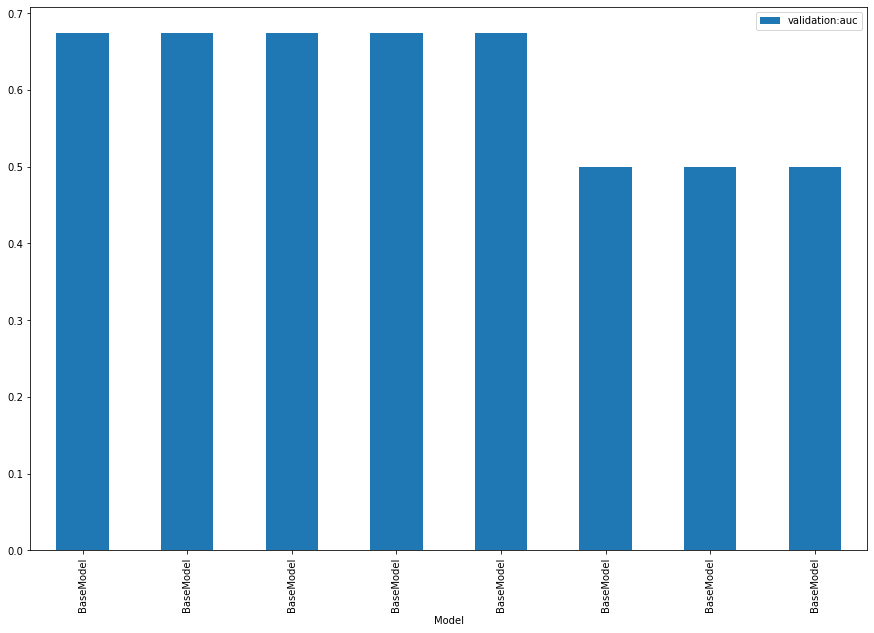

In [27]:
ModelsResults=ModelsResults.sort_values('validation:auc', ascending=False)
fig = plt.figure()
fig.set_size_inches([15, 10])
ModelsResults.plot.bar('Model', 'validation:auc',ax=plt.gca())

In [34]:
ModelsResults[['Model', 'train:auc', 'validation:auc','subsample']]

,Model,train:auc,validation:auc,subsample
5,BaseModel,0.71374,0.67460,0.7
3,BaseModel,0.71337,0.67440,0.5
6,BaseModel,0.71091,0.67394,0.8
4,BaseModel,0.71448,0.67388,0.6
7,BaseModel,0.71303,0.67358,1.0
0,BaseModel,0.50000,0.50000,0.2
1,BaseModel,0.50000,0.50000,0.3
2,BaseModel,0.50000,0.50000,0.4


In [38]:
#Additional results from training for custom processing: feature importance, evaluation scores of tests data and full model output of training and validation scores
ModelEvalResults=pd.DataFrame()
FI = pd.DataFrame()
ModelsTestScores = pd.DataFrame()
for index, row in ModelsResults.iterrows():
    print('%s-%s'%(row['Model'],index))
    eval_results_file=row['ModelFile'].replace('model.tar.gz','output.tar.gz').replace('s3://%s/'%bucket,'')
    print(eval_results_file)
    if s3.exists(row['ModelFile'].replace('model.tar.gz','output.tar.gz')):
        sagemaker_session.download_data(path=temp_folder, bucket=bucket, key_prefix=eval_results_file)
        print('Processing...')
        eval_results_file=os.path.join(temp_folder, 'output.tar.gz')
        with tarfile.open(eval_results_file) as tar:
            tar.extractall(path=temp_folder)
        eval_results_file=os.path.join(temp_folder, 'eval_results.csv')
        eval_results=pd.read_csv(eval_results_file, error_bad_lines=False, index_col=False)
        eval_results['Model']=row['Model']
        eval_results['ind']=index
        ModelEvalResults = pd.concat([ModelEvalResults,eval_results])
        #FI
        if (GetFIFlg=='Y'):
            fi_model_file=os.path.join(temp_folder, 'fi.csv')     
            if (os.path.isfile(fi_model_file)):
                fi_model=pd.read_csv(fi_model_file, error_bad_lines=False, index_col=False)
                fi_model['feature']=fi_model['feature'].map(GetMap(model))
                fi_model['Model']=row['Model']
                fi_model['ind']=index     
                FI = pd.concat([FI,fi_model])           
        #Test Scores 
        if (GetTestScoreFlg=='Y'):
            test_score_file=os.path.join(temp_folder, 'test_score.csv')
            if (os.path.isfile(test_score_file)):
                test_score=pd.read_csv(test_score_file, error_bad_lines=False, index_col=False)
                test_score['Model']=row['Model']
                test_score['ind']=index 
                ModelsTestScores = pd.concat([ModelsTestScores,test_score])       
    else:
        print('File does not exist')       
ModelEvalResults=ModelEvalResults[['Model','ind','train','valid']]  
if (GetFIFlg=='Y'):
    FI=FI[['Model','ind','feature','gain','weight','cover']]
if (GetTestScoreFlg=='Y'):
    ModelsTestScores=ModelsTestScores[['Model','ind','roc-auc-test']]

BaseModel-5
Models/Experiments/subsample/BaseModel-5-2021-02-08-17-01-31/output/output.tar.gz
Processing...
BaseModel-3
Models/Experiments/subsample/BaseModel-3-2021-02-08-17-01-27/output/output.tar.gz
Processing...
BaseModel-6
Models/Experiments/subsample/BaseModel-6-2021-02-08-17-01-35/output/output.tar.gz
Processing...
BaseModel-4
Models/Experiments/subsample/BaseModel-4-2021-02-08-17-01-30/output/output.tar.gz
Processing...
BaseModel-7
Models/Experiments/subsample/BaseModel-7-2021-02-08-17-01-36/output/output.tar.gz
Processing...
BaseModel-0
Models/Experiments/subsample/BaseModel-0-2021-02-08-17-01-22/output/output.tar.gz
Processing...
BaseModel-1
Models/Experiments/subsample/BaseModel-1-2021-02-08-17-01-24/output/output.tar.gz


/home/kate/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Processing...
BaseModel-2
Models/Experiments/subsample/BaseModel-2-2021-02-08-17-01-26/output/output.tar.gz
Processing...


2. Feature Importance

In [39]:
if (GetFIFlg=='Y'):
    FI=FI.sort_values(['Model','ind','gain'], ascending=False)
    print(FI.head())

       Model  ind          feature      gain weight        cover
0  BaseModel    7        yearbuilt  3.658830   1262  2010.437432
1  BaseModel    7  cova_deductible  3.447266    556  2469.986845
2  BaseModel    7             sqft  1.678978   1336   836.614528
5  BaseModel    7   usagetype_encd  1.611597    354   547.703281
4  BaseModel    7      landlordind  1.569687    122   735.945679


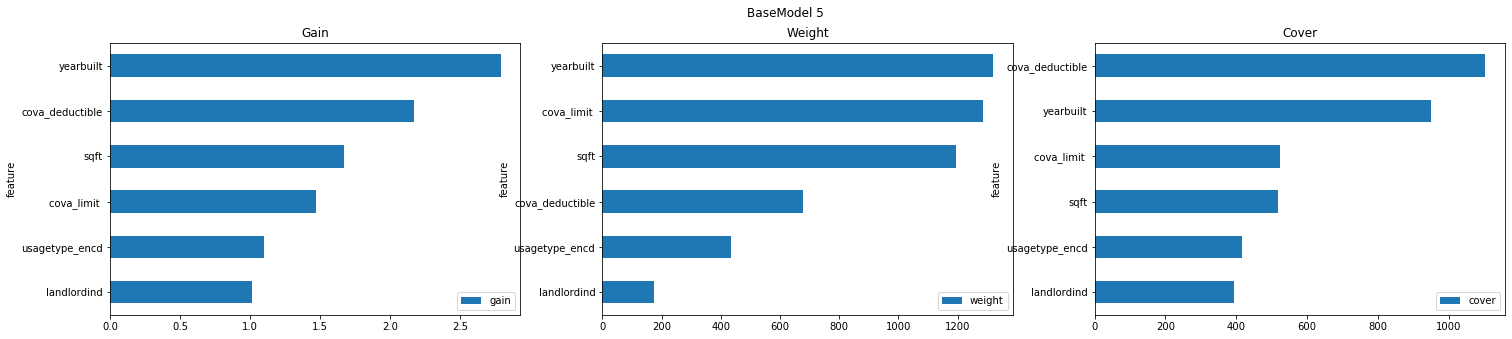

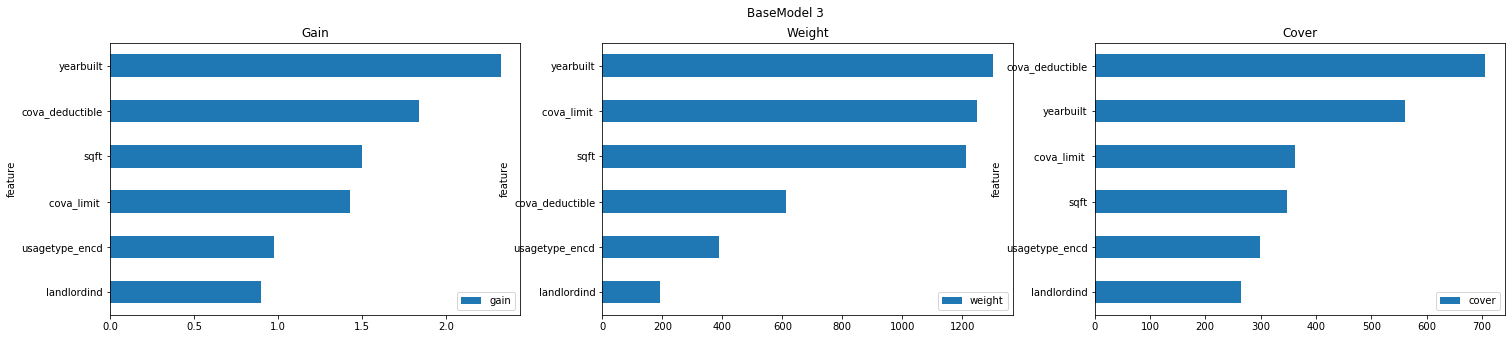

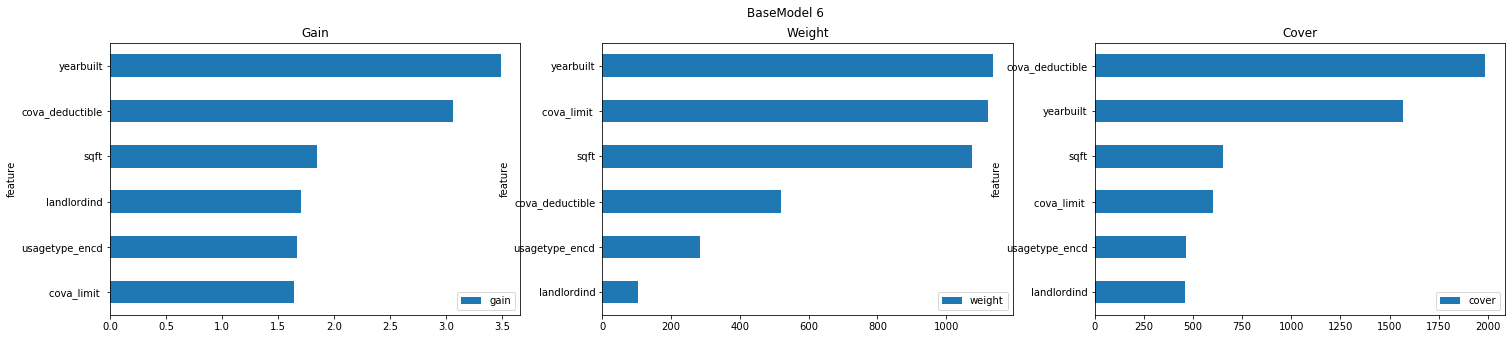

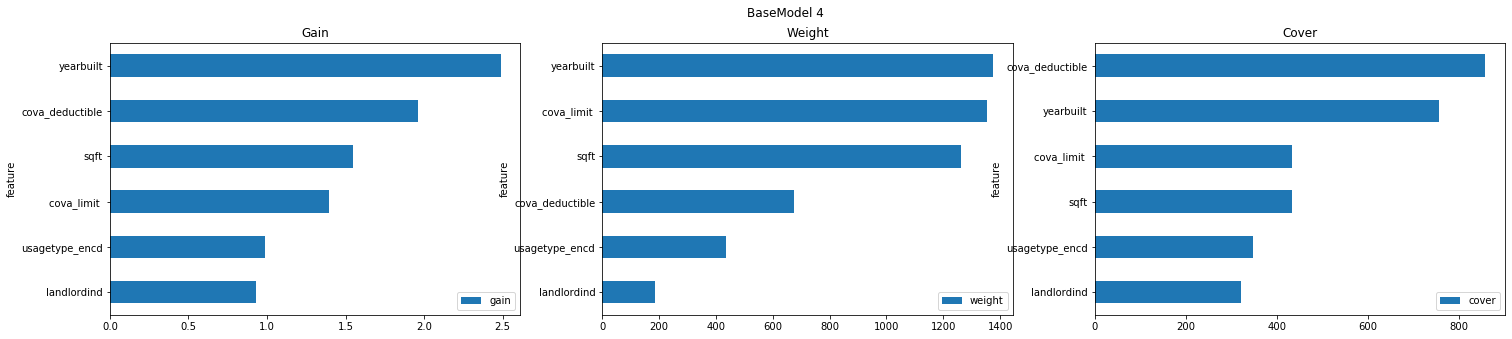

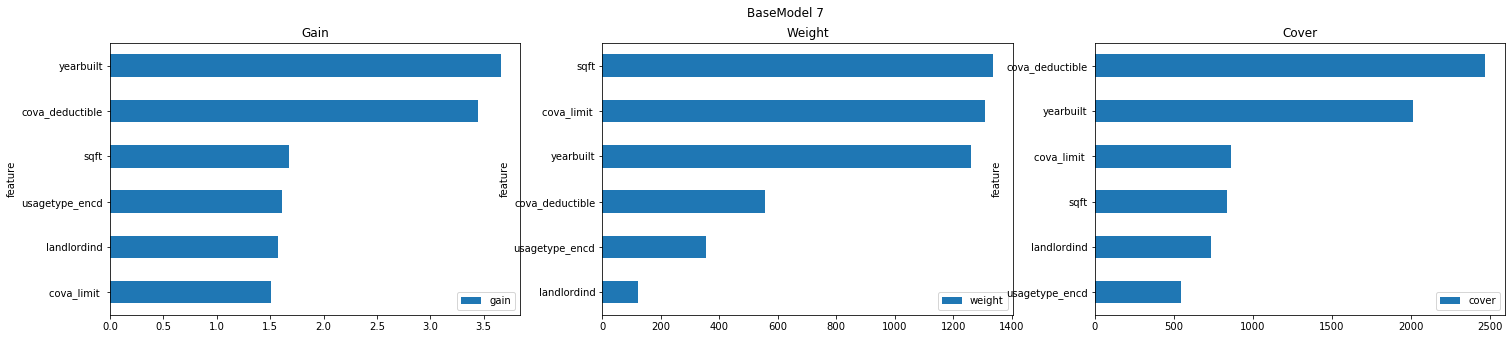

In [40]:
if (GetFIFlg=='Y'):
    for index, row in ModelsResults.iterrows():
        if len(FI[( (FI['Model']==row['Model']) & (FI['ind']==index))])>0:
            
            data=FI[( (FI['Model']==row['Model']) & (FI['ind']==index))]
            fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(25,5)) 
            fig.suptitle('%s %s'%(row['Model'],index))
            data=data.sort_values(['Model','ind','gain'], ascending=True)
            ax = axs[0]
            ax.set_title('Gain')
            data.plot.barh('feature', 'gain',ax=axs[0])
            
            
            data=data.sort_values(['Model','ind','weight'], ascending=True)
            ax = axs[1]
            ax.set_title('Weight')
            data.plot.barh('feature', 'weight',ax=axs[1])
            
            data=data.sort_values(['Model','ind','cover'], ascending=True)
            ax = axs[2]
            ax.set_title('Cover')
            data.plot.barh('feature', 'cover',ax=axs[2])


3.Test dataset Scores

In [32]:
if (GetTestScoreFlg=='Y'):
    print(ModelsTestScores)

         Model  ind  roc-auc-test
0  BaseModel-7    5      0.700648
0  BaseModel-7    3      0.700162
0  BaseModel-7    6      0.701770
0  BaseModel-7    4      0.699278
0  BaseModel-7    7      0.701575
0  BaseModel-7    0      0.500000
0  BaseModel-7    1      0.500000
0  BaseModel-7    2      0.500000


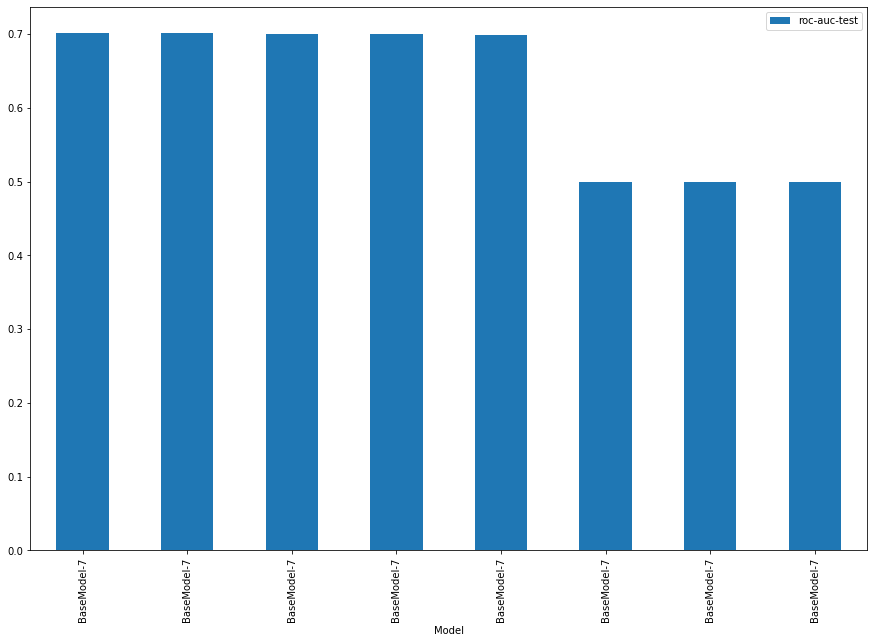

In [33]:
if (GetTestScoreFlg=='Y'):
    ModelsTestScores=ModelsTestScores.sort_values('roc-auc-test', ascending=False)
    fig = plt.figure()
    fig.set_size_inches([15, 10])
    ModelsTestScores.plot.bar('Model', 'roc-auc-test',ax=plt.gca())

4. Training and validation errors (output from the model) to estimate overfitting

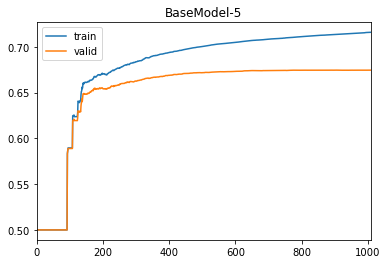

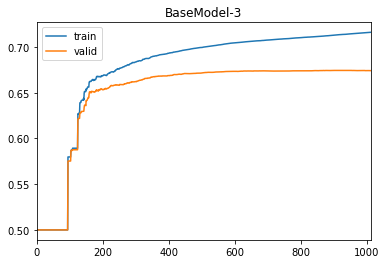

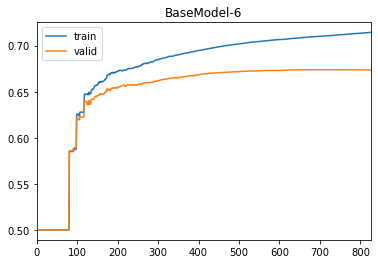

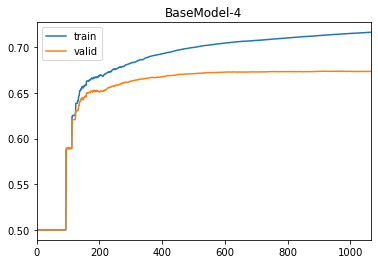

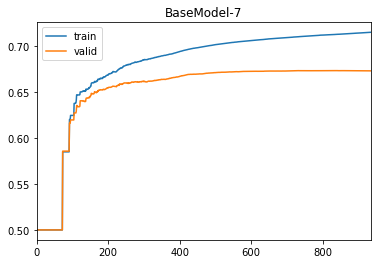

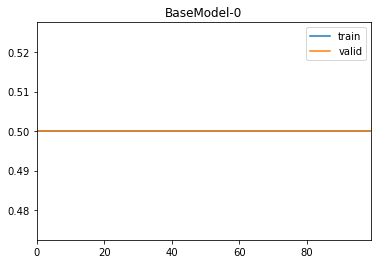

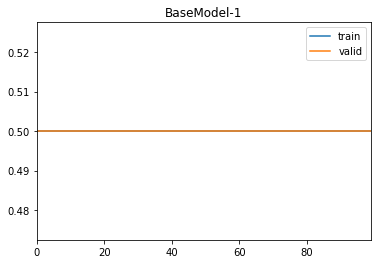

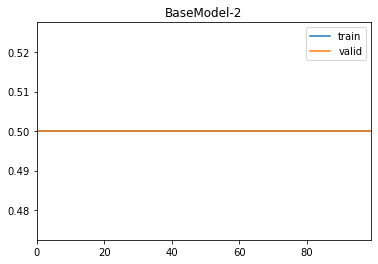

In [41]:
for index, row in ModelsResults.iterrows():
    if len(ModelEvalResults[( (ModelEvalResults['Model']==row['Model']) & (ModelEvalResults['ind']==index))])>0:
        ModelEvalResults[( (ModelEvalResults['Model']==row['Model']) & (ModelEvalResults['ind']==index))][['train','valid']].plot(title=row['Model']+'-'+str(index))

In [ ]:
#Saving into the Experiment log file models results
#eu.SaveToExperimentLog(Experiments_file, '%s EvalResults'%Experiment_name, ModelEvalResults)

In [ ]:
#Saving models artifacts into the Experiment Log file
#eu.SaveToExperimentLog(Experiments_file, '%s ModelFiles'%Experiment_name, ModelsFiles)